In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import shap
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# Quad Trees T2 original space

In [2]:
quad_times_3 = pd.read_csv("deps/time_quad_T2_knn_3.csv")

In [3]:
quad_times_3.head()

,query_id,rep,elapsed_us
0,0,0,48.4
1,1,0,59.1
2,2,0,58.4
3,3,0,57.5
4,4,0,32.4


In [4]:
# Συλλογή mean, median και std για κάθε query
# επαναλαμβάνεται το ίδιο query ανά n_queries 
reps = 10
n_queries = len(quad_times_3) // reps

means = np.zeros((n_queries, 2))
medians =  np.zeros((n_queries, 2))
stds = np.zeros((n_queries, 2))

for i in range(n_queries):
    means[i, 0] = int(i)
    medians[i, 0] = int(i)
    stds[i, 0] = int(i)
    
    means[i, 1] = quad_times_3[i::n_queries]['elapsed_us'].mean()
    medians[i, 1] = quad_times_3[i::n_queries].sort_values("elapsed_us").iloc[reps//2].elapsed_us
    stds[i, 1] = quad_times_3[i::n_queries]['elapsed_us'].std()

In [5]:
medians[:,1].mean()

44.59039

In [6]:
# outlier
quad_times_3[3630::n_queries]

,query_id,rep,elapsed_us
3630,3630,0,638.1
13630,3630,1,77.1
23630,3630,2,45.9
33630,3630,3,45.0
43630,3630,4,45.7
53630,3630,5,45.9
63630,3630,6,46.6
73630,3630,7,47.1
83630,3630,8,45.9
93630,3630,9,45.3


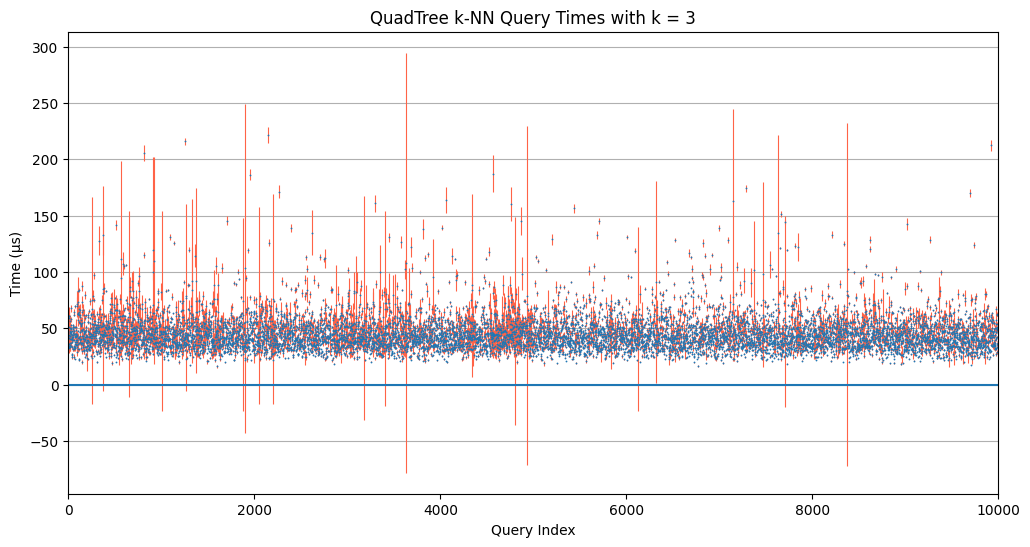

In [7]:
# yerr plot με mean και std
x = range(len(means))
plt.figure(figsize=(12,6))
plt.errorbar(x, means[:,1], yerr=stds[:,1], fmt='o', ecolor='tomato',
             capsize=0,              
             elinewidth=0.8,        
             markeredgewidth=0,    
             markersize=1.3)

plt.xlabel('Query Index')
plt.ylabel('Time (μs)')
plt.title('QuadTree k-NN Query Times with k = 3')
plt.grid(axis="y")
plt.xlim(0, 10000)
# plt.savefig("plots/quad_time_yerr_k_3", bbox_inches ="tight")
plt.axhline(y=0)
plt.show()

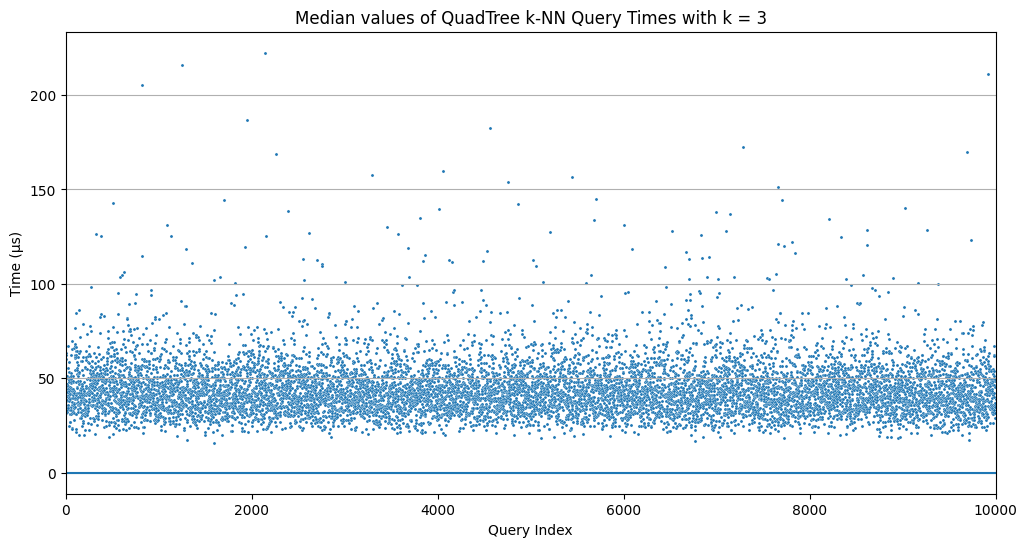

In [8]:
# Διάγραμμα με τα medians
x = range(len(means))
plt.figure(figsize=(12,6))
sns.scatterplot(x = medians[:,0], y = medians[:,1], s = 5)

plt.xlabel('Query Index')
plt.ylabel('Time (μs)')
plt.title('Median values of QuadTree k-NN Query Times with k = 3')
plt.grid(axis="y")
plt.xlim(0, 10000)
# plt.savefig("plots/median_quad_time_yerr_k_3", bbox_inches ="tight")
plt.axhline(y=0)
plt.show()

(0.0, 180.0)

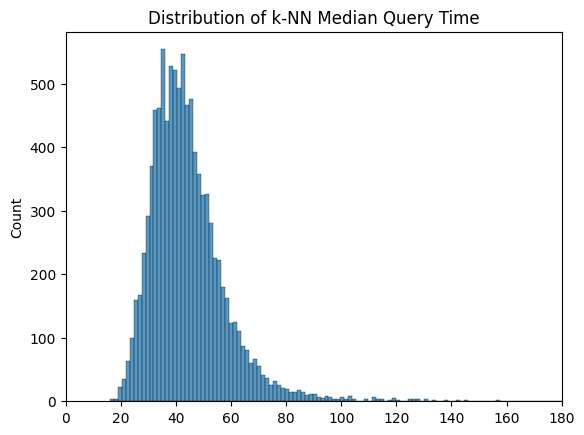

In [9]:
# Κατανομή median χρόνων
sns.histplot(medians[:,1])
plt.title("Distribution of k-NN Median Query Time")
plt.xlim(0, 180)
# plt.savefig("plots/quad_median_time_hist_k_3", bbox_inches ="tight")

(0.0, 180.0)

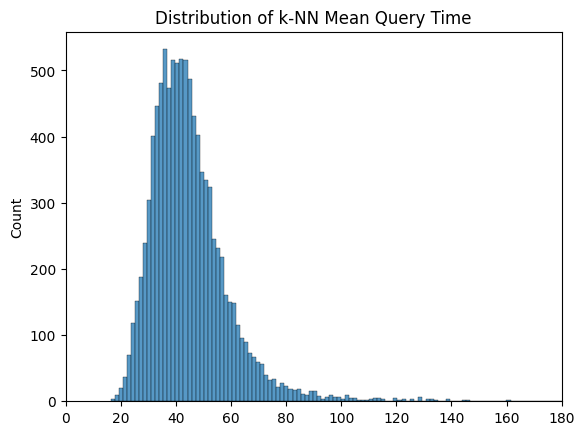

In [10]:
# Κατανομή mean χρόνων
sns.histplot(means[:,1])
plt.title("Distribution of k-NN Mean Query Time")
plt.xlim(0, 180)
# plt.savefig("plots/quad_mean_time_hist_k_3", bbox_inches ="tight")

In [11]:
means = pd.DataFrame(means, columns = ['query_id', 'elapsed_us'])

In [12]:
medians = pd.DataFrame(medians, columns = ['query_id', 'elapsed_us'])

In [13]:
queries = pd.read_csv("deps/USA_c0.01%_n10000_p.csv", header=None, names=["x", "y"])
queries["query_id"] = queries.index

medians = pd.DataFrame(medians).sort_values(by="elapsed_us").reset_index(drop=True)

In [14]:
queries.head()

,x,y,query_id
0,-102.36200,45.64965,0
1,-82.15970,39.01165,1
2,-109.52000,38.43120,2
3,-89.06465,36.96315,3
4,-95.04865,42.10660,4


In [15]:
def plot_queries(queries, stats, title="Query Points Colored by Median Query Time", save=False, use_log=True):
    # merge των df για χρωματισμό των queries σύμφωνα με τον χρόνο τους
    merged = pd.merge(queries, stats, on="query_id")
    times = merged["elapsed_us"].to_numpy()
    
    if use_log: # λογαριθμικό διάγραμμα
        times = np.log1p(times)

    times_norm = (times - times.min()) / (times.max() - times.min())  # Κανονικοποίηση για χρώμα 0-1
    cmap = plt.cm.viridis
    colors = cmap(times_norm)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(merged["x"], merged["y"], c=colors, s=30, edgecolor='k', alpha=0.8)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title + (" (log scale)" if use_log else ""))
    
    cbar = plt.colorbar(scatter)
    cbar.set_label("Normalized " + ("log " if use_log else "") + "Median Query Time (elapsed_μs)")
    
    plt.grid(True, linestyle='--', alpha=0.5)
    if save:
        plt.savefig(f"plots/{save}", bbox_inches="tight")
    plt.show()

In [16]:
times = medians.iloc[:,1]

Text(0.5, 0.98, 'Distribution of Median Time (μsec)')

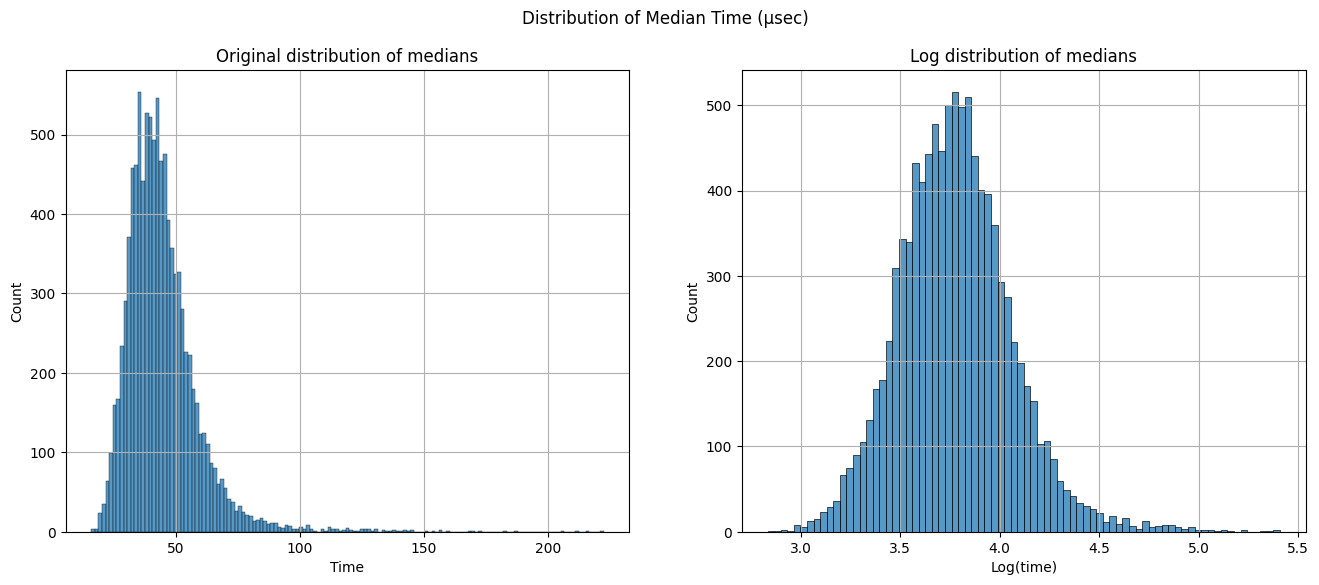

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

sns.histplot(times, ax=ax1)
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_title("Original distribution of medians")

sns.histplot(np.log1p(times), ax=ax2)
ax2.set_xlabel("Log(time)")
ax2.grid()
ax2.set_title("Log distribution of medians")

plt.suptitle("Distribution of Median Time (μsec)")

# plt.savefig("plots/quad_median_time_hist_k_3.png", bbox_inches ="tight")

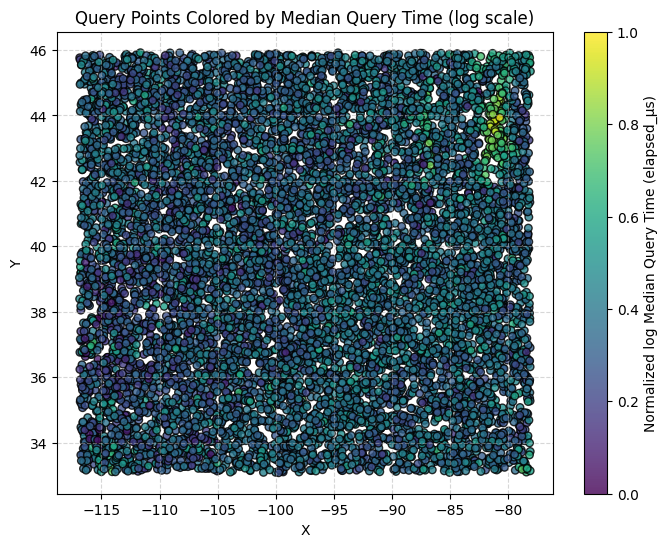

In [18]:
plot_queries(queries, medians)

## Quad Trees T2 rotated

In [19]:
quad_times = pd.read_csv("deps/time_quad_T2_knn_3_rotate.csv")

In [20]:
quad_times.head()

,query_id,rep,elapsed_us
0,0,0,70.7
1,1,0,57.8
2,2,0,54.0
3,3,0,47.8
4,4,0,43.6


In [21]:
reps = 10
n_queries = len(quad_times) // reps

means = np.zeros((n_queries, 2))
medians_r =  np.zeros((n_queries, 2))
stds = np.zeros((n_queries, 2))

for i in range(n_queries):
    means[i, 0] = int(i)
    medians_r[i, 0] = int(i)
    stds[i, 0] = int(i)
    
    means[i, 1] = quad_times[i::n_queries]['elapsed_us'].mean()
    medians_r[i, 1] = quad_times[i::n_queries].sort_values("elapsed_us").iloc[reps//2].elapsed_us
    stds[i, 1] = quad_times[i::n_queries]['elapsed_us'].std()

In [22]:
rot_distr = np.log(medians_r[:,1])

In [23]:
or_distr = np.log(medians.iloc[:,1])

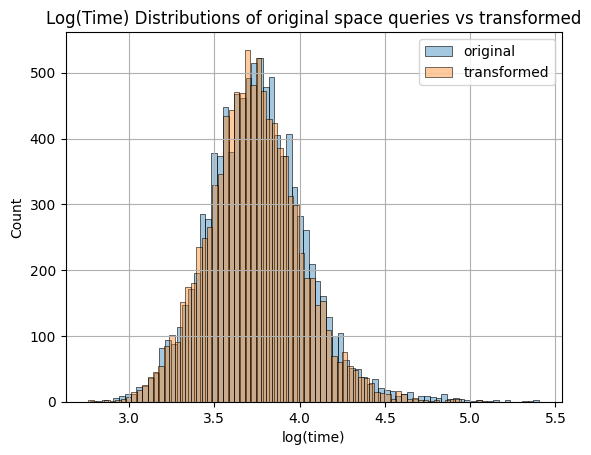

In [24]:
sns.histplot(or_distr, alpha=0.4, label="original")
sns.histplot(rot_distr, alpha=0.4, label="transformed")
plt.grid()
plt.xlabel("log(time)")
plt.title("Log(Time) Distributions of original space queries vs transformed")
plt.legend()
# plt.savefig("plots/dist_diff.png", bbox_inches ="tight")

In [25]:
stat, p_value = ttest_rel(rot_distr, or_distr)
print(f"p-value: {p_value}")

p-value: 1.4862440668800226e-06


In [26]:
medians_r[:,1].mean()

43.434740000000005

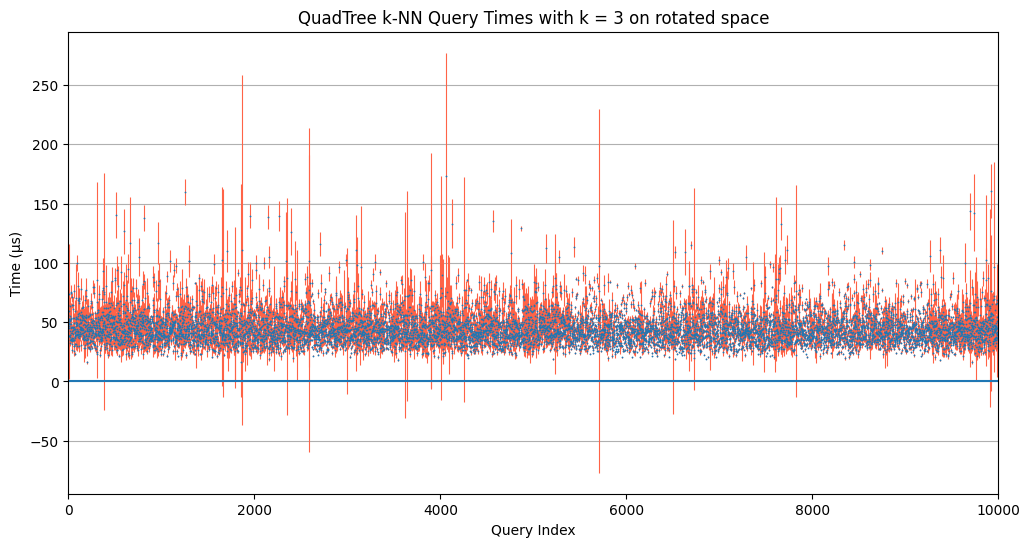

In [27]:
x = range(len(means))
plt.figure(figsize=(12,6))
plt.errorbar(x, means[:,1], yerr=stds[:,1], fmt='o', ecolor='tomato',
             capsize=0,              
             elinewidth=0.8,        
             markeredgewidth=0,    
             markersize=1.3)

plt.xlabel('Query Index')
plt.ylabel('Time (μs)')
plt.title('QuadTree k-NN Query Times with k = 3 on rotated space')
plt.grid(axis="x")
plt.grid()
plt.xlim(0, 10000)
# plt.savefig("plots/quad_time_yerr_k_3_rotated.png", bbox_inches ="tight")
plt.axhline(y=0)
plt.show()

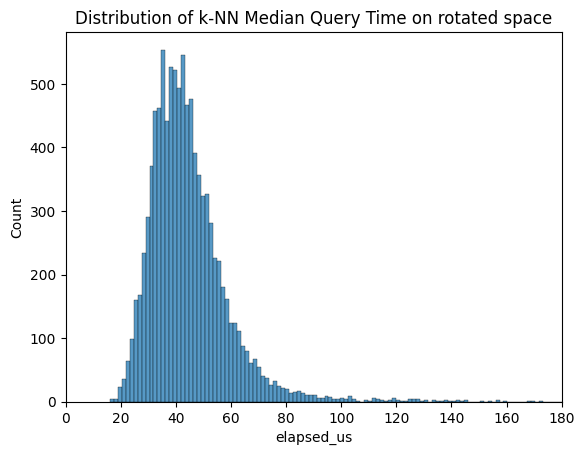

In [28]:
sns.histplot(medians.iloc[:,1])
plt.title("Distribution of k-NN Median Query Time on rotated space")
plt.xlim(0, 180)
plt.savefig("plots/quad_median_time_hist_k_3_rotated.png", bbox_inches ="tight")

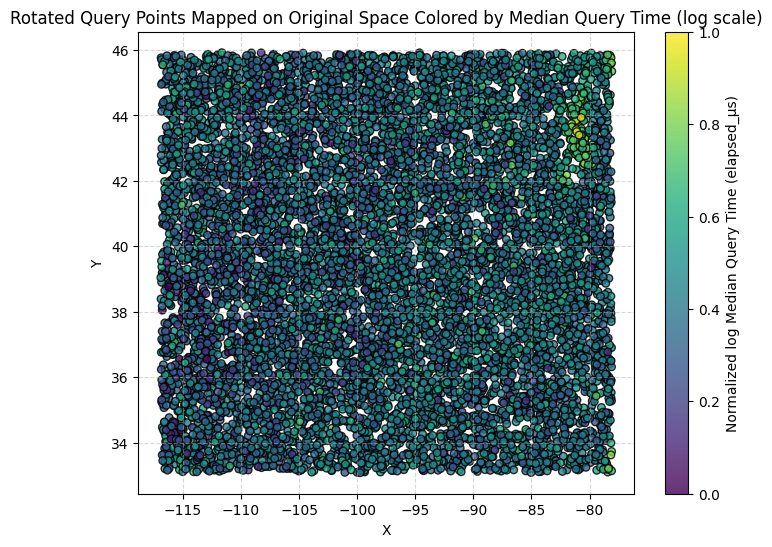

In [29]:
means = pd.DataFrame(means, columns = ['query_id', 'elapsed_us'])
means = pd.DataFrame(means).sort_values(by="elapsed_us").reset_index(drop=True)

plot_queries(queries, means, title =  "Rotated Query Points Mapped on Original Space Colored by Median Query Time")

In [30]:
ro = pd.read_csv("deps/quadtree_rotation_results.csv")

In [31]:
ro.head()

,rotation_deg,mean_us,stddev_us,max_depth,min_depth,avg_pts_per_leaf,stddev_pts,q1,q3,total_leaves,internal_nodes
0,0,38.5,1.35,16,3,13.26,7.74,8,18,172024,57341
1,1,37.4,0.52,15,3,13.24,7.74,8,18,172198,57399
2,2,37.2,0.42,17,3,13.27,7.75,8,18,171856,57285
3,3,37.9,0.32,16,3,13.31,7.76,8,18,171379,57126
4,4,38.0,0.00,16,3,13.26,7.74,8,18,171979,57326


Text(0.5, 0.98, 'Depth Vs Time')

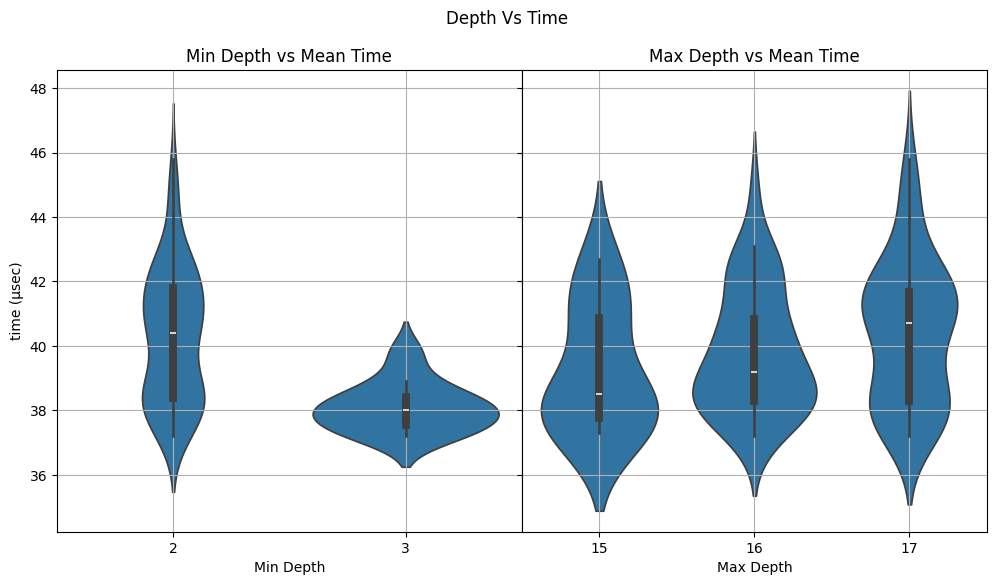

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)
plt.subplots_adjust(wspace=0)

sns.violinplot(data = ro, x = "min_depth", y = "mean_us", ax=ax1)
ax1.grid()
ax1.set_xlabel("Min Depth")
ax1.set_ylabel("time (μsec)")
ax1.set_title("Min Depth vs Mean Time")

sns.violinplot(data = ro, x = "max_depth", y = "mean_us", ax=ax2)
ax2.set_title("Max Depth vs Mean Time")
ax2.set_xlabel("Max Depth")
ax2.grid()

plt.suptitle("Depth Vs Time")
# plt.savefig("plots/depth_vs_time.png", bbox_inches ="tight")

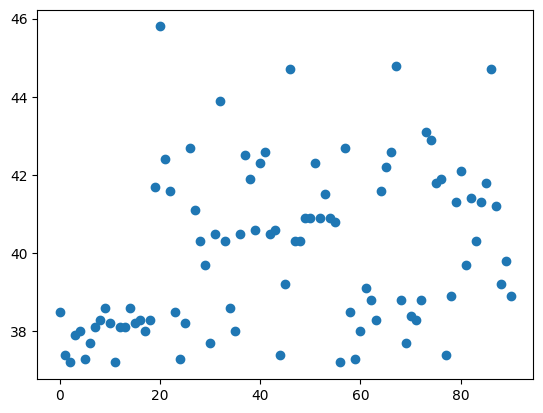

In [33]:
plt.scatter(ro["rotation_deg"], ro['mean_us'])

In [34]:
X = ro.drop(columns=["rotation_deg", "mean_us"])
y = ro["mean_us"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# search για το καλύτερο υποσύνολο των χαρακτητιστικών
best_score = -np.inf
best_subset = None
best_model = None
for k in range(1, len(X.columns) + 1):
    for subset in combinations(X.columns, k):
        X_train_sub, X_test_sub = X_train[list(subset)], X_test[list(subset)]
        reg = DecisionTreeRegressor(max_depth=4, random_state=42)
        reg.fit(X_train_sub, y_train)
        score = r2_score(y_test, reg.predict(X_test_sub))
        if score > best_score:
            best_score = score
            best_subset = subset
            best_model = reg

print("Best R²:", best_score)
print("Best Subset:", best_subset)

Best R²: 0.17714613806734425
Best Subset: ('stddev_us', 'stddev_pts', 'q1', 'q3')


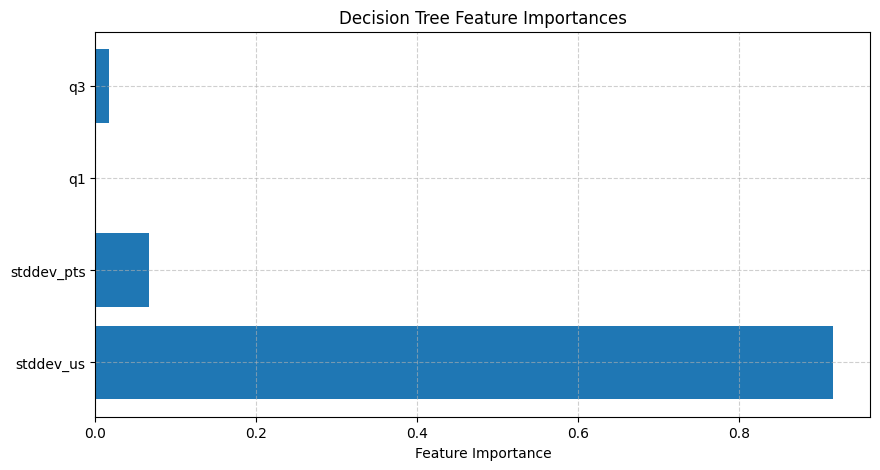

In [36]:
# feature importance
features = X.columns
importances = best_model.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(best_subset, importances)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importances")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

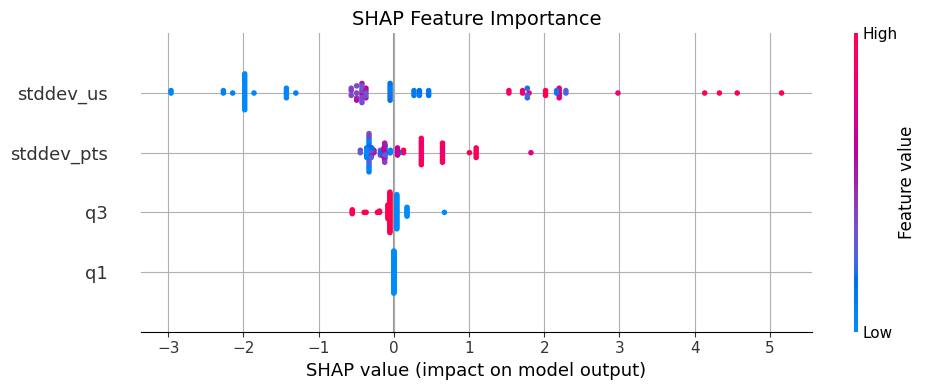

In [37]:
# shap values
X = pd.DataFrame(X, columns=best_subset)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X) 
    
shap.summary_plot(
    shap_values, 
    X, 
    feature_names=best_subset,
    show=False,
    plot_size=(10,4)
)
plt.grid()
plt.title("SHAP Feature Importance", fontsize=14)
plt.tight_layout()
# plt.savefig("plots/shap.png")
plt.show()